# BLS API
### U.S. Bureau of Labor Statistics (BLS) Application Programming Interface

This notebook offers two examples of using python to request economic data from the BLS API. The first example requests the labor force participation rate from the BLS v1 API. The second example requests unemployment rates by race/origin, and shows a method for requesting multiple series over a longer period of time using the v2 API.

### Background
#### BLS
You can read more about BLS [here](https://www.bls.gov/bls/infohome.htm).

> The Bureau of Labor Statistics of the U.S. Department of Labor is the principal Federal agency responsible for measuring labor market activity, working conditions, and price changes in the economy.

#### API
BLS-data-related tasks that are exploratory, repetitive, or need to be well documented, can make use of the API to save time. The API allows users to request data with specific parameters, such as the BLS series ID, dates, or preferred format. Data returned can be fed into pandas or other programs for further calculations and analysis.

#### Python

The examples use Python version 2.7 and the requests, json, and pandas packages. 

### Example 1: Basic Request--Single Series from API v1

#### API location

The version 1 API, which does not require registration, is located at the URL `base_url` below

In [1]:
# BLS API v1 url
base_url = 'https://api.bls.gov/publicAPI/v1/timeseries/data/'

#### BLS series id

The [BLS data site](https://www.bls.gov/data/) offers different search tools to find the series ID for the data of interest. In this case, I'm going to type out a python dictionary with two keys and two values. The first key is the word `id` and its value is the BLS series ID. The second key is `name` and its value is a short descriptive name that corresponds to the series. 

In [2]:
# BLS series id for the civilian labor force participation rate
series = {'id': 'LNS11300000', 
          'name': 'Labor Force Participation Rate'}

#### Combine base url and series id

Combine the base url and series id into a single string which is the API url with data. Print a link to the data. 

In [3]:
data_url = '{}{}'.format(base_url, series['id'])
print data_url

https://api.bls.gov/publicAPI/v1/timeseries/data/LNS11300000


#### Request data from data url

Use the requests package to get data from the `data_url`. By specifying that the data are in json format, we convert the output to nested python dictionaries and lists. The status of the request is printed and the top-level dictionary is stored as variable `r`. 

In [4]:
import requests

r = requests.get(data_url).json()
print 'Status: ' + r['status']

Status: REQUEST_SUCCEEDED


#### Check latest data value

The dictionary r contains several keys.

In [5]:
print r.keys()

[u'status', u'message', u'Results', u'responseTime']


The `Results` key contains the `series` list, of which the first item (python lists start with item `0`) contains our data: `r['Results']['series'][0]['data']`. The data are a list of dictionaries with the first item (`[0]`) being the most recent set of values, footnotes, and date information, printed below.

In [35]:
r = r['Results']['series'][0]['data']
print r[0]

{u'footnotes': [{}], u'periodName': u'July', u'period': u'M07', u'value': u'62.9', u'year': u'2017'}


#### Read into pandas

To make further calculations, such as to find the average value over the series, and to graph the results, we can use the pandas package. We create a dataframe by telling pandas the index, data, and name. Since the data in this case are a monthly time series, we can identify that the index for the series contains dates. Below a list of dates, which will be the index of the dataframe, is constructed from the values obtained using the period and year dictionary keys seen above. The first column of the pandas dataframe is the series values, named with the series id. Just in case they contain relevant information, and footnotes are included as a second column.

In [55]:
import pandas as pd

dates = ['{} {}'.format(i['period'], i['year']) for i in r]
index = pd.to_datetime(dates)
data = {series['id']: [float(i['value']) for i in r], 
        'footnotes': [i['footnotes'][0] for i in r]}

df = pd.DataFrame(index=index, data=data).iloc[::-1]

df.tail(3)

,LNS11300000,footnotes
2017-05-01,62.7,{}
2017-06-01,62.8,{}
2017-07-01,62.9,{}


#### Plot the results

Calculate the average value for the perios and plot both the monthly and average values to look for trends.

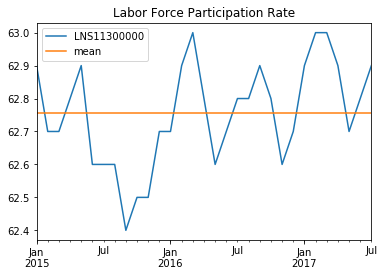

In [57]:
%matplotlib inline

df['mean'] = df[series['id']].mean()
df[[series['id'], 'mean']].plot(title=series['name'])

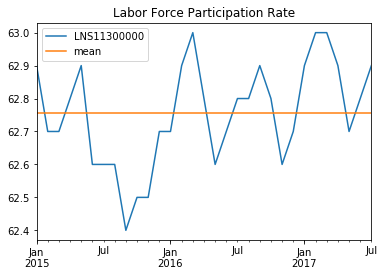

In [60]:
import matplotlib.pyplot as plt

df[[series['id'], 'mean']].plot(title=series['name'])

plt.savefig('ex1.png')

#### Summary

The first example creates a url containing the requested data by combining a base url of the API with the BLS series ID of interest. The result is a dataframe with monthly data, starting in January 2015, on the labor force participation rate. The plot above let's us quickly see when and my how much the series deviated from its full-period average. The example uses the v1 API, so the number of requests is limited as is the functionality. For more complex requests, a technique such as the one shown in example 2 is preferable. 

### Example 2: Requesting multiple series and specific dates
The second examples uses the BLS API v2 (which requires free [registration](https://data.bls.gov/registrationEngine/)) to request more than one series at the same time. The version 2 API has a higher daily query limit, allows more years and series to be returned in each query, and allows some additional options such as requesting data in percent change rather than level. See [difference between v1 and v2](https://www.bls.gov/developers/api_faqs.htm#register1).

#### Parameters 

The new url, registration key, and data parameters are shown below.

In [61]:
import config # .py file with bls_key = 'API key here'

# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
key = '?registrationkey={}'.format(config.bls_key)

# Series stored as a dictionary
series_dict = {
    'LNS14000003': 'White', 
    'LNS14000006': 'Black', 
    'LNS14000009': 'Hispanic'}

# Start year and end year
dates = ('2008', '2017')

#### Post request for the data

This examples is more complex as the request includes some additional information. Previously we used a *get* request, but if we want to submit data to be processed by the API we need to use a *post* request. See: [What is the difference between POST and GET?](https://stackoverflow.com/questions/3477333/what-is-the-difference-between-post-and-get) for more information.  

The json package will help to put our series and year parameters in the format readable by the BLS API. The headers and data sent with our request contain these parameters. 

In [62]:
import json

# Specify json as content type to return
headers = {'Content-type': 'application/json'}

# Submit the list of series as data
data = json.dumps({
    "seriesid": series_dict.keys(),
    "startyear": dates[0], 
    "endyear": dates[1]})

# Post request for the data
p = requests.post(
    '{}{}'.format(url, key), 
    headers=headers, 
    data=data).json()['Results']['series']

#### Loop through series and convert to pandas format

Since the API returns data in a uniform way, a loop can be used to apply formatting or other changes to all series in the returned json data. In the example below, all three series are converted to pandas series with a datetime index and the values converted to floats. 

In [63]:
# Empty dictionary to fill with values
d = {}

# Build a pandas series from the API results, p
for s in p:
    d[series_dict[s['seriesID']]] = pd.Series(
        index = pd.to_datetime(
            ['{} {}'.format(i['period'], i['year']) for i in s['data']]),
        data = [i['value'] for i in s['data']]
        ).astype(float).iloc[::-1]
    
# Combine series into one pandas dataframe
df = pd.DataFrame(d)

# Show last 5 results
df.tail()

,Black,Hispanic,White
2017-03-01,8.0,5.1,3.9
2017-04-01,7.9,5.2,3.8
2017-05-01,7.5,5.2,3.7
2017-06-01,7.1,4.8,3.8
2017-07-01,7.4,5.1,3.8


#### Plot the results

The series are plotted below to show how they compare.

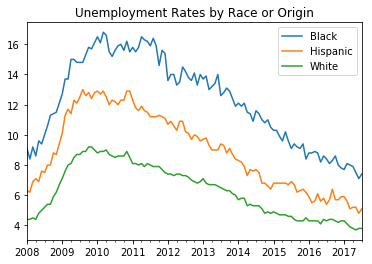

In [64]:
# Simple line plot of the data
df.plot(title='Unemployment Rates by Race or Origin')
plt.savefig('ex2.png')

#### Conclusion

The v2 API allows for more complex requests to be filled. In this case, we can use the API to very quickly plot the latest data on unemployment rates.